# Project 3 - Subreddit Classification
### by Steven Tran

| **Notebooks** |
|-----------|
|[01_Data_Collection](01_Data_Collection.ipynb)|
|[02_Cleaning_and_EDA.ipynb](02_Cleaning_and_EDA.ipynb)|
|[03_Preprocessing_Modeling_and_Tuning](03_Preprocessing_Modeling_and_Tuning.ipynb)|
|[04_Production_Model_and_Conclusion](04_Production_Model_and_Conclusion.ipynb)|

---

# 03: Preprocessing, Modeling, and Tuning


In [1]:
# imports:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

#logistic regression model:
from sklearn.linear_model import LogisticRegression

#K-nearest neighbors classifier:
from sklearn.neighbors import KNeighborsClassifier


#If we have time, use xgboost too:
from xgboost import XGBClassifier

#Metrics:
from sklearn.metrics import plot_confusion_matrix, accuracy_score, recall_score, precision_score, roc_curve, plot_roc_curve


# using this option from lesson 5.05 modeling with VADER to display more text in columns:
pd.options.display.max_colwidth = 200

#read in data:
df = pd.read_csv('../data/cleaned/unpopularopinions.csv')

# In this notebook...

I'll aim to proceed as follows:

1. Generate a **null model**, the results of which will serve as our baseline for model performance.
1. Instantiate a few model pipelines which will consist of
     * a text vectorizer (`TfidfVectorizer`) and 
     * a classifier (`LogisticRegression`, `RandomForestClassifier`, `XGBoost`)
1. Compare models' performance together and against the baseline.


---

## Preprocessing

To start, we'll **define X and y**. As explored in the [02_Cleaning_and_EDA](02_Cleaning_and_EDA.ipynb), it's unlikely the `title` and `selftext` word count, string lenth and count/length ratio fields will be very predictive of the subreddit. This goes for the compound sentiment for these fields as well. 

This suggests the specific words included in either of the fields will be the most predictive. To simplify the vectorization and modeling, we'll combine the sets of lemmatized words from both fields into one.


In [2]:
df['text'] = df['title_lemma'] + ' ' + df['selftext_lemma']

With that transformation done, we can assign the `text` of each reddit post as the predictor variable **X** and the `subreddit` target field to be **y**. To reiterate, `subreddit = 1` if the post came from **/r/UnpopularOpinion** and `subreddit = 0` if the post came from **/r/Rant**.

In [3]:
X = df['text']
y = df['subreddit']
print(X.shape, y.shape)

(15715,) (15715,)


Before we model, apply a train-test split on the data to set aside some samples for model validation. The classes are balanced, but we'll stratify on the target **y** anyway.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, stratify=y)
print(f'Training shapes: X:{X_train.shape} y:{y_train.shape} | Testing shapes: X:{X_test.shape} y:{y_test.shape}')

Training shapes: X:(11786,) y:(11786,) | Testing shapes: X:(3929,) y:(3929,)


---

## The Null Model

A simple baseline model against which to compare would be to predict that every post in the sample is from **/r/UnpopularOpinion**. Under this crude model, the predictions would be correct approximately 51% of the time:

In [5]:
y_test.value_counts(normalize=True)

1    0.509035
0    0.490965
Name: subreddit, dtype: float64

#### **The baseline accuracy to beat with our modeling is 51%**.

---

## Modeling and Tuning

For our modeling, I will use the following classifiers to attempt to predict whether a given post belongs to **/r/UnpopularOpinion** or **/r/Rant**:

* LogisticRegression
* KNearestNeighbors
* XGBoost 

For each of these models, we'll be using `pipelines` along with `TfidfVectorizer` to vectorize the text. I'll also add GridSearchCV to the mix to determine what the best vectorizer hyperparameters might be.

First I'll instantiate a container for our models' scores:

In [6]:
accuracies = {}
accuracies['baseline'] = {'train': y_test.mean(), 'test': y_test.mean()}

In [7]:
accuracies

{'baseline': {'train': 0.5090353779587682, 'test': 0.5090353779587682}}

Also, to plot confusion matrices, we'll pass the following variable as the `display_labels` parameter argument:

In [8]:
matrix_labels = ['/r/Rant','/r/UnpopularOpinion']

In [9]:
#some custom stopwords
from sklearn.feature_extraction import text
custom_stopwords = ['fuck','mad', 'really','fucking','just','like','know', 'unpopular', 'opinion', 'evil', 'ody','ama','hoes','chrome','filler', 'orange', 'green', 'yellow', 'canker']
stopwords = text.ENGLISH_STOP_WORDS.union(custom_stopwords)

---

### LogisticRegression

In [10]:
#instantiate pipeline:
logreg_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression())
])

#set pipeline parameters
lr_pipe_params = {
    'tfidf__stop_words': ['english',stopwords],
    'tfidf__max_features': [2000,3500,5000],
    'tfidf__min_df': [2,3],
    'tfidf__max_df': [.9, .95],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'logreg__max_iter': [10000,20000],
    'logreg__C': [.1,1.0]
}

#instantiate gridsearchcv
lr_gs = GridSearchCV(logreg_pipe,
                     lr_pipe_params,
                     cv=5,
                     n_jobs=-1)

#fit gridsearchcv:
lr_gs.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('logreg', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logreg__C': [0.1, 1.0],
                         'logreg__max_iter': [10000, 20000],
                         'tfidf__max_df': [0.9, 0.95],
                         'tfidf__max_features': [2000, 3500, 5000],
                         'tfidf__min_df': [2, 3],
                         'tfidf__ngram_range': [(1, 1), (1, 2)],
                         'tfidf__stop_words': ['english',
                                               frozenset({'a', 'about', 'above',
                                                          'across', 'after',
                                                          'afterwards', 'again',
                                                          'against', 'all',
                                                          'almost', 'alone',
              

In [11]:
#first add the accuracy score to our scorekeeping variable:
accuracies['logistic_regression'] = {'train': lr_gs.score(X_train,y_train), 'test': lr_gs.score(X_test,y_test)}
print(accuracies['logistic_regression'])

{'train': 0.8824876972679451, 'test': 0.8271824891829982}


Not bad! Our model gets about 82% of classification predictions correct. Let's review how it's doing that:

In [12]:
lr_gs.best_score_

0.8266582892601864

In [13]:
lr_gs.best_params_

{'logreg__C': 1.0,
 'logreg__max_iter': 10000,
 'tfidf__max_df': 0.9,
 'tfidf__max_features': 5000,
 'tfidf__min_df': 3,
 'tfidf__ngram_range': (1, 2),
 'tfidf__stop_words': 'english'}

The parameters used by the best model fit in the grid search used the top 5,000 most frequently occurring terms in the corpus. Further, the `ngram_range` hyperparameter of `(1,2)` indicates it checked for both unigrams (single-word terms) and bigrams (consecutive two-word terms).

In [14]:
lr_gs.score(X_train,y_train), lr_gs.score(X_test,y_test)

(0.8824876972679451, 0.8271824891829982)

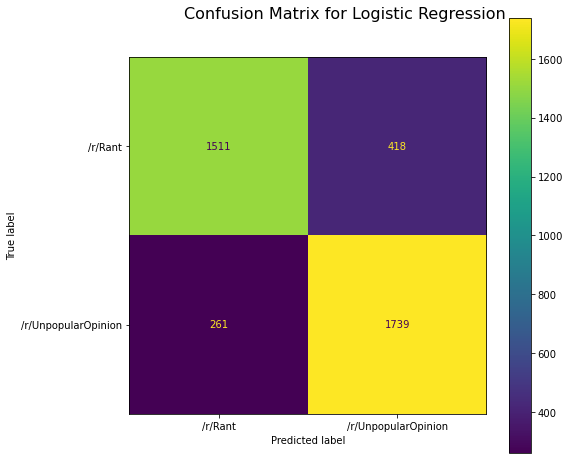

In [15]:
#plot the confusion matrix
f, ax = plt.subplots(1,1,figsize=(8,8))
plt.suptitle('Confusion Matrix for Logistic Regression', y = .90, fontsize=16)
plot_confusion_matrix(lr_gs,X_test,y_test,cmap='viridis',display_labels=matrix_labels, ax=ax);

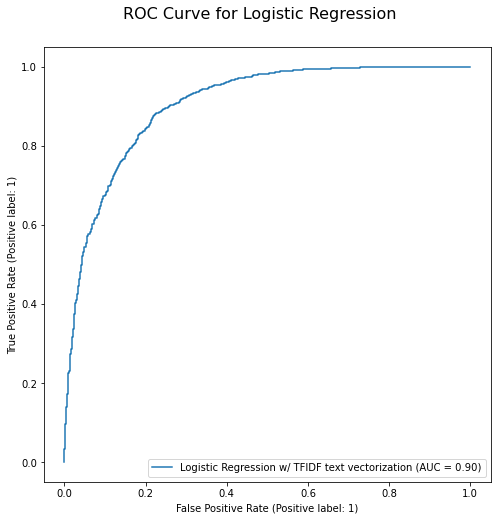

In [16]:
#plot roc curve:
f, ax = plt.subplots(1,1,figsize=(8,8))
f.suptitle('ROC Curve for Logistic Regression', y = 0.95, fontsize=16)
plot_roc_curve(lr_gs,X_test,y_test,name='Logistic Regression w/ TFIDF text vectorization', ax=ax);

---

### K-Nearest Neighbors

In [17]:
#instantiate pipeline:
knn_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])

#set pipeline parameters:
knn_pipe_params = {
    'tfidf__stop_words': ['english',stopwords],
    'tfidf__max_features': [2000,3500,5000],
    'tfidf__min_df': [2,3],
    'tfidf__max_df': [.9, .95],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'knn__n_neighbors': [3,5,7,9],
}

#instantiate gridsearch cv:
knn_gs = GridSearchCV(knn_pipe,
                      knn_pipe_params,
                      cv = 5,
                      n_jobs=-1)

#fit gridsearch:
knn_gs.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [3, 5, 7, 9],
                         'tfidf__max_df': [0.9, 0.95],
                         'tfidf__max_features': [2000, 3500, 5000],
                         'tfidf__min_df': [2, 3],
                         'tfidf__ngram_range': [(1, 1), (1, 2)],
                         'tfidf__stop_words': ['english',
                                               frozenset({'a', 'about', 'above',
                                                          'across', 'after',
                                                          'afterwards', 'again',
                                                          'against', 'all',
                                                          'almost', 'alone',
                                                          'along', 

In [18]:
#first add the accuracy score to our scorekeeping variable:
accuracies['knn'] = {'train': knn_gs.score(X_train,y_train), 'test':knn_gs.score(X_test,y_test) }
print(accuracies['knn'])

{'train': 0.5055150178177499, 'test': 0.5034359888012216}


Ouch. K-Nearest Neighors does not look to be very good at predicting which subreddit our posts belong in.

In [19]:
knn_gs.best_score_

0.5715242669499438

In [20]:
knn_gs.best_params_

{'knn__n_neighbors': 9,
 'tfidf__max_df': 0.9,
 'tfidf__max_features': 5000,
 'tfidf__min_df': 3,
 'tfidf__ngram_range': (1, 1),
 'tfidf__stop_words': 'english'}

With a much lower best score, and using only unigrams, KNN is clearly not very good at making these predictions.

In [21]:
knn_gs.score(X_train,y_train), knn_gs.score(X_test,y_test)

(0.5055150178177499, 0.5034359888012216)

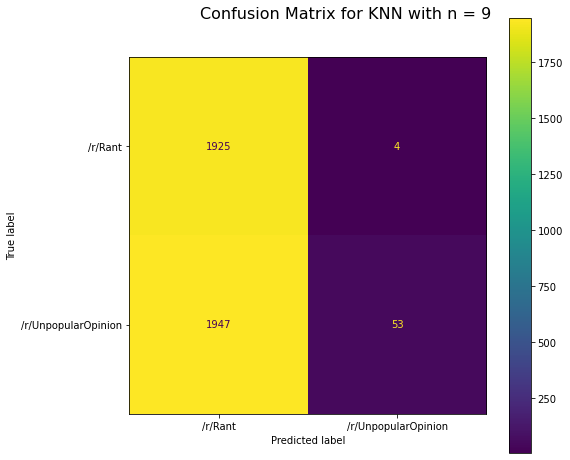

In [22]:
#plot the confusion matrix
f, ax = plt.subplots(1,1,figsize=(8,8))
plt.suptitle('Confusion Matrix for KNN with n = 9', y = .90, fontsize=16)
plot_confusion_matrix(knn_gs,X_test,y_test,cmap='viridis',display_labels=matrix_labels, ax=ax);

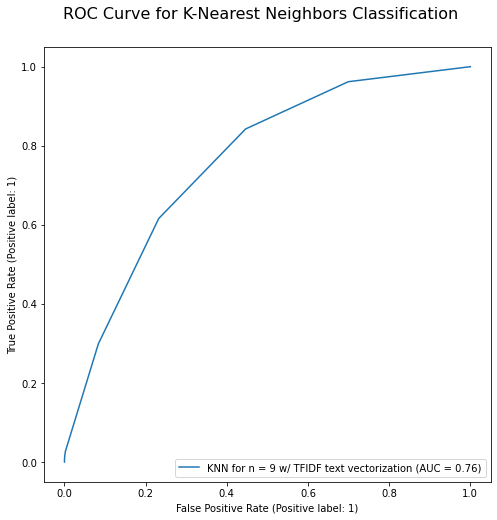

In [23]:
#plot roc curve:
f, ax = plt.subplots(1,1,figsize=(8,8))
f.suptitle('ROC Curve for K-Nearest Neighbors Classification', y = 0.95, fontsize=16)
plot_roc_curve(knn_gs,X_test,y_test,name='KNN for n = 9 w/ TFIDF text vectorization', ax=ax);

---

### XGBoost

In [24]:
#instantiate pipeline
xgb_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('xgbc', XGBClassifier())
])

#set pipeline parameters:
xgb_pipe_params = {
    'tfidf__stop_words': ['english',stopwords],
    'tfidf__max_features': [5000],
    'tfidf__min_df': [3],
    'tfidf__max_df': [.9],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'xgbc__max_depth': [3,5],
    'xgbc__min_child_weight': [1,10]
}

#instantiate gridsearchcv:
xgb_gs = GridSearchCV(xgb_pipe,
                      xgb_pipe_params,
                      cv=5,
                      n_jobs=-1)

#fit gridsearch:
xgb_gs.fit(X_train,y_train)

C:\Users\yumst\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:38:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('xgbc',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      gamma=None, gpu_id=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                         

In [25]:
#first add the accuracy score to our scorekeeping variable:
accuracies['xgbc'] = {'train': xgb_gs.score(X_train,y_train), 'test': xgb_gs.score(X_test,y_test)}
print(accuracies['xgbc'])

{'train': 0.9114203292041405, 'test': 0.8136930516670908}


In [26]:
xgb_gs.best_score_

0.8134217711089592

In [27]:
xgb_gs.best_params_

{'tfidf__max_df': 0.9,
 'tfidf__max_features': 5000,
 'tfidf__min_df': 3,
 'tfidf__ngram_range': (1, 2),
 'tfidf__stop_words': 'english',
 'xgbc__max_depth': 5,
 'xgbc__min_child_weight': 1}

In [28]:
xgb_gs.score(X_train,y_train), xgb_gs.score(X_test,y_test)

(0.9114203292041405, 0.8136930516670908)

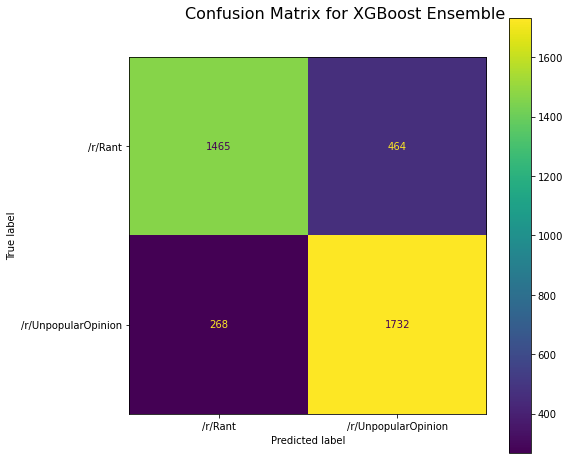

In [29]:
#plot the confusion matrix
f, ax = plt.subplots(1,1,figsize=(8,8))
plt.suptitle('Confusion Matrix for XGBoost Ensemble', y = .90, fontsize=16)
plot_confusion_matrix(xgb_gs,X_test,y_test,cmap='viridis',display_labels=matrix_labels, ax=ax);

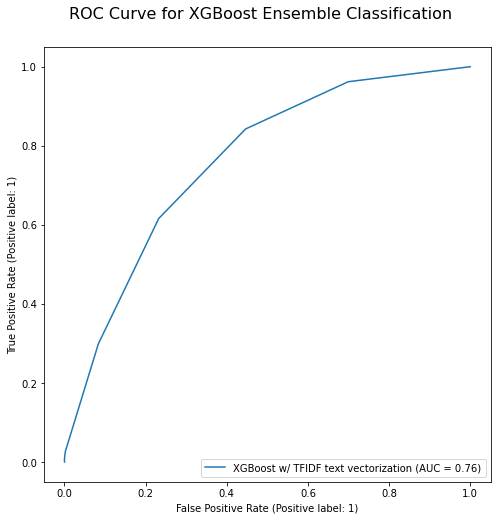

In [30]:
#plot roc curve:
f, ax = plt.subplots(1,1,figsize=(8,8))
f.suptitle('ROC Curve for XGBoost Ensemble Classification', y = 0.95, fontsize=16)
plot_roc_curve(knn_gs,X_test,y_test,name='XGBoost w/ TFIDF text vectorization', ax=ax);

---

## Evaluate

In [31]:
results = pd.DataFrame(accuracies).T

In [32]:
results['diff'] = results['train'] - results['test']

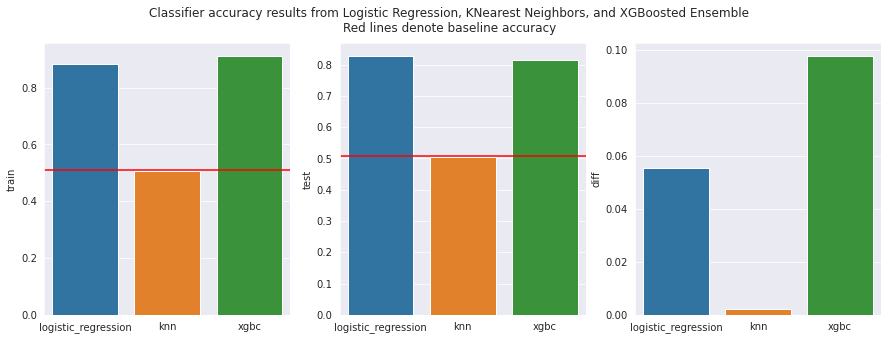

In [33]:
with sns.axes_style("darkgrid"):
    fig, axs = plt.subplots(1,3,figsize=(15,5))
    
    fig.suptitle('Classifier accuracy results from Logistic Regression, KNearest Neighbors, and XGBoosted Ensemble' + \
                 '\nRed lines denote baseline accuracy')
    
    #plot train:
    axs[0].axhline(y=results.loc['baseline','train'], color='red')
    sns.barplot(x=results.index[1:],y=results['train'][1:],ax=axs[0])
    
    
    #plot test:
    axs[1].axhline(y=results.loc['baseline','test'], color = 'red')
    sns.barplot(x=results.index[1:],y=results['test'][1:],ax=axs[1])
    
    
    #plot difference:
    sns.barplot(x=results.index[1:],y=results['diff'][1:],ax=axs[2])

Despite having remarkably low variance, the **K-Nearest Neighbors** classifier resulted in predictions that were worse than the established baseline. It's probably safe to say it's not a competitive contender for the best classifier among these three.

**Logistic Regression** and **XGBoosted Ensemble** produced similar accuracies in predicting the test data. However, the variance in score between training and testing data was nearly double for XGBoost compared to Logistic Regression.

So we'll use Logistic Regression as our production model to determine which words are most commonly associated with unpopular opinions.